In [1]:
import sys
import os 
%load_ext autoreload
%autoreload 2

os.chdir("/home/cooper-cooper/Desktop/vans/")

sys.path[0] = "/home/cooper-cooper/Desktop/vans/"


from utilities.variational import Autoencoder
import tensorflow_quantum as tfq
from utilities.qmodels import QNN,EnergyLoss

import tensorflow as tf

from utilities.evaluator import Evaluator
import numpy as np

import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm
from utilities.variational import VQE
import cirq

from datetime import datetime

from utilities.variational import VQE
from utilities.evaluator import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer_autoencoder import UnitaryMurder
from utilities.misc import scheduler_selector_temperature, scheduler_parameter_perturbation_wall #this outputs always 10 for now.



### load pure states

indexed_pure_states=[]
resolver_pure_states=[]
train_bonds=[]
energsin=[]
js=np.linspace(0.5,2.3,16)[0::3]
for bond in js:
    problem_config ={"problem" : "H2", "geometry": str([('H', (0., 0., 0.)), ('H', (0., 0., bond))]).replace("\'",""), "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":4,"problem_config":problem_config, "load_displaying":False}
    evaluator_load = Evaluator(args,loading=True, path="../data-vans/")
    #energies.append(evaluator.raw_history[len(list(evaluator.raw_history.keys()))-1][-1])
    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True)
    _, cuener, indexed_circuit, resolver, bestener,low = evaluator_load.evolution[len(evaluator_load.evolution)]
    energsin.append(cuener)
    indexed_pure_states.append(indexed_circuit)
    resolver_pure_states.append(resolver)
    train_bonds.append(bond)
    
auto_handler = Autoencoder(n_qubits=4,problem_config=problem_config, nb=1, lr = 0.01,
                        epochs=5000, verbose=0,
                        patience=200, optimizer="adam",
                        many_indexed_circuits=indexed_pure_states, many_symbols_to_values=resolver_pure_states)



In [5]:

au_evaluator = Evaluator(args={"n_qubits":4,
                            "problem_config":{"problem":"AutoencoderH2","n_qubits":3},
                            "noise_config":{}},
                      info="", 
                      path="../data-vans/", acceptance_percentage=1e-5,
                      accuracy_to_end=0., reduce_acceptance_percentage=True,loading=True,nrun_load=18)

In [14]:
W, cost, indexed_circuit, resolver, best_infidelity,_ = au_evaluator.evolution[au_evaluator.get_best_iteration()]

inverse_indexed_circuit, inversolver, Wdagger = auto_handler.give_inverse(indexed_circuit,resolver)
Wdagger = cirq.unitary(Wdagger)


In [33]:

def compute_fidelity(input_state, encoding, channel, decoding):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.round(np.dot(np.conjugate(input_state),st), 16)

def compute_energy(input_state, encoding, channel, decoding, observable):
    """
    we assume input_state is a ket.
    """
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return np.dot(np.conjugate(st),np.dot(observable,st))

def give_approximate_state(input_state, encoding, channel, decoding):
    st = np.dot(encoding, input_state)
    st = np.dot(channel, st)
    st = np.dot(decoding, st)
    return st

In [18]:
from utilities.misc import give_kronecker_of_list

projector = give_kronecker_of_list([auto_handler.zero_proj(vqe_handler.qubits[k]).matrix() for k in range(auto_handler.nb)])
channel = np.kron(projector, np.eye(2**(len(auto_handler.qubits)-auto_handler.nb)))

In [25]:
[compute_fidelity(cirq.unitary(auto_handler.qbatch[k])[:,0], cirq.unitary(W), channel,Wdagger) for k in range(len(auto_handler.qbatch))]

[(0.9999991733713816+0j),
 (0.9999989365603904+4e-16j),
 (0.9999997312573126+2e-16j),
 (0.9999998538771886+2e-16j),
 (0.9999989494288652+0j),
 (0.999999436190993-2e-16j)]

In [29]:
obs=[]
for bond in js:
    problem_config ={"problem" : "H2", "geometry": str([('H', (0., 0., 0.)), ('H', (0., 0., bond))]).replace("\'",""), "multiplicity":1, "charge":0, "basis":"sto-3g"}
    args={"n_qubits":4,"problem_config":problem_config, "load_displaying":False}
    evaluator_load = Evaluator(args,loading=True, path="../data-vans/")
    #energies.append(evaluator.raw_history[len(list(evaluator.raw_history.keys()))-1][-1])
    vqe_handler = VQE(n_qubits=4,noise_config={}, problem_config=problem_config,
                            return_lower_bound=True)
    
    obs.append(sum(vqe_handler.observable).matrix())

In [43]:
replicas1 = [cirq.unitary(auto_handler.qbatch[k])[:,0] for k in range(len(auto_handler.qbatch))]
replicas = [give_approximate_state(cirq.unitary(auto_handler.qbatch[k])[:,0], cirq.unitary(W), channel,Wdagger) for k in range(len(auto_handler.qbatch))]

In [44]:
enes=[]
for s,o in zip(replicas, obs):
    n=np.dot(np.conjugate(s), np.dot(o, s))
    enes.append(n)
    
enes1=[]
for s,o in zip(replicas1, obs):
    n=np.dot(np.conjugate(s), np.dot(o, s))
    enes1.append(n)

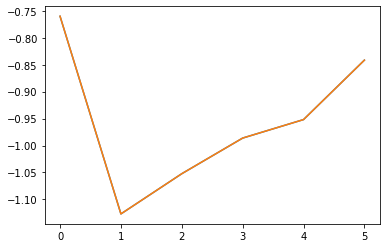

In [45]:
plt.plot(enes)
plt.plot(enes1)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


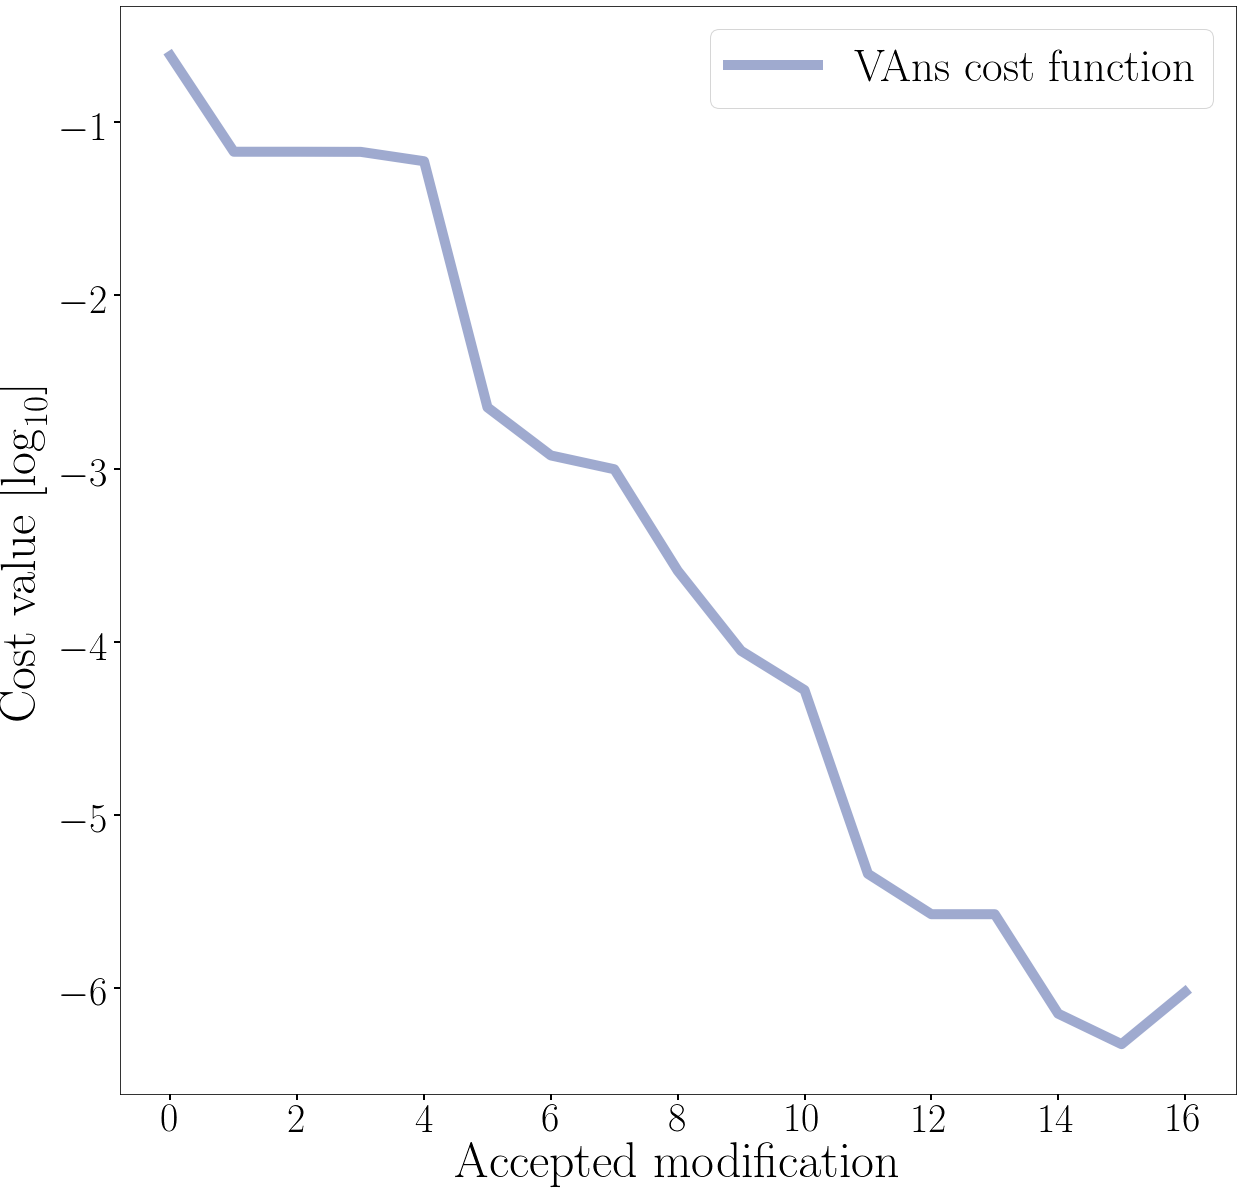

In [46]:

cost_value=[]
for k in list(au_evaluator.evolution.values()):
    cost_value.append(k[1])
    
    

color1="#D79922"
color2="#4056A1"
color3="#F13C20"
color4="#5D001E"
color5="#8E8D8A"
import matplotlib

plt.style.use('results/plots/style.mplstyle')
matplotlib.rc("text",usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

import matplotlib.colors as colors
converter = colors.ColorConverter()
plt.rcParams.update({'font.size': 45})


plt.figure(figsize=(20,20))
plt.plot(np.log10(cost_value),color=converter.to_rgb(color2),linewidth=10,alpha=0.5,label="VAns cost function")
plt.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5,labelsize=40)
#plt.xticks([0.5,2.0,1.0,1.5,2.0,2.3])
plt.xlabel("Accepted modification")
plt.ylabel("Cost value "+r'$[\log _{10}]$')
plt.legend(prop={"size":45})
plt.savefig("cost_value_separable.pdf",format="pdf")